In [19]:
import numpy as np
import pandas as pd
import misc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import laplace, norm, gmean
# from tqdm.notebook import tqdm
from tqdm import tqdm
from bsm import bsm

pd.options.display.max_columns=300
pd.options.display.max_rows=100

In [20]:
# Get data from yahoo finance
misc.get_price_data('SPY')
df = pd.read_csv('datasets/stock_price_series/SPY.csv')
df = misc.clean_df(df)
df = df.set_index('date')
df['close daily change'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
df = df.dropna()
df

,open,high,low,close,adjclose,volume,ticker,close daily change
date,,,,,,,,
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397581,480500,SPY,0.007112
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451406,201300,SPY,0.002119
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720440,529400,SPY,0.010571
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828053,531500,SPY,0.004184
1993-02-05,44.968750,45.062500,44.718750,44.968750,25.810101,492100,SPY,-0.000694
...,...,...,...,...,...,...,...,...
2023-03-03,399.709991,404.450012,399.029999,404.190002,404.190002,90038300,SPY,0.016038
2023-03-06,405.049988,407.450012,404.010010,404.470001,404.470001,72795900,SPY,0.000693
2023-03-07,404.420013,404.670013,397.630005,398.269989,398.269989,108310600,SPY,-0.015329


In [43]:
df
(44.343750 - 44.250000) / 44.250000

0.00211864406779661

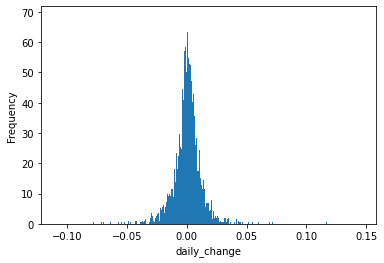

In [22]:
# Distribution of daily returns
count, bins, ignored = plt.hist(df['close daily change'], 1000, density=True)
plt.ylabel('Frequency')
plt.xlabel('daily_change')
plt.show()

(0.00035990639857369576, 0.011938126573499568)


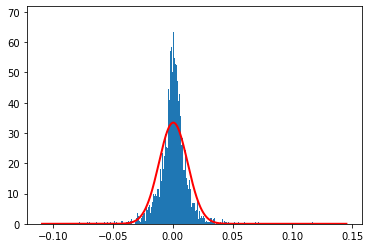

In [23]:
# Fit normal distribution parameters
norm_params = norm.fit(df['close daily change'])
print(norm_params)

# Plot daily return distribution
count, bins, ignored = plt.hist(df['close daily change'], 1000, density=True)

# Plot normal distribution with parameters
mu, sigma = norm_params
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

Laplace Distribution:

https://arxiv.org/ftp/arxiv/papers/1906/1906.10325.pdf

(0.0005963675422870013, 0.007940583654808073)


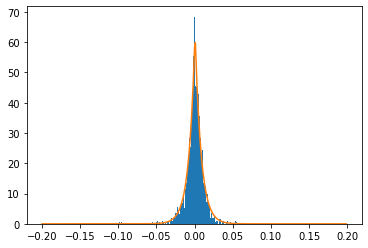

In [24]:
# Fit Laplace distribution parameters
laplace_params = laplace.fit(df['close daily change'])
print(laplace_params)

# Plot daily returns distribution
count, bins, ignored = plt.hist(df['close daily change'], 1000, density=True)

# Plot Laplace distribution with parameters
loc, scale = laplace_params
x = np.arange(-0.2, 0.2, .001)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf)

The laplace distribution appears to be fit SPY daily returns distribution more closely.

We calculate the historical volatility of SPY for use in the BSM equation.

\begin{equation}
    \sigma_{annual} = \sigma_{daily} \times \sqrt{252}
\end{equation}

In [25]:
spy_hist_vol = np.std(df['close daily change']) * np.sqrt(252)
print("SPY Historical Volatility: " + "{:.2f}".format(spy_hist_vol * 100) + " %")

SPY Historical Volatility: 18.95 %


In [44]:
from strategy_testing import fit_laplace
test = df['close'].copy()
test = np.array(test)
test1 = (test[1:] - test[:-1])/test[:-1]
test2 = np.array(df['close daily change'])

print(test1)
print(test2)

[ 0.00211864  0.01057082  0.0041841  ... -0.01532873  0.00163212
 -0.01844985]
[ 0.00711238  0.00211864  0.01057082 ... -0.01532873  0.00163212
 -0.01844985]
